Here we study various global local update proposals to Markov Chain Monte Carlo. 
1. Local Update
2. Uniform Update
3. Exchange Update
4. Hamiltonian Update
5. Tempering

First we compute the proposal matrix. 
Then we compute the transition matrix.
Then we find the eigenvalues of the transition matrix
And we compare the spectral gaps for varying system sizes and temperature. 

In [55]:
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt

In [19]:
def spin_x(n, qubit_index):
  X = np.array([[0, 1], [1, 0]])
  I = np.eye(2)
  ops = [I] * n
  ops[qubit_index] = X
  result = ops[0]
  for op in ops[1:]:
    result = np.kron(result, op)
  return result

In [43]:
def get_int_to_spinconfig(number:int, n:int):
    # Let i be the input for number entry above. This number is between 0 to 2^(n)-1 where n is the positive integer power deciding the number of slots in the binary rep of i
    # The output of this function will be [1,-1]^n which will be achieved by converting i to binary first and replacing every 0 bit with -1
    #Thus if i=0 === [-1,-1,-1....-1_n]
    #        i=1 === [-1,-1,-1....1_n]   # least sig bit flipped to 1
    #      i=2^n -1 == [1,1,1....1_n]    # all bits flipped
    if number < 0 or number > (2**n-1):
        raise ValueError('number out of range')

    bin_list = list( np.binary_repr(number,n))
    return np.array([-1 if bit=='0' else 1 for bit in bin_list])


def get_spinconfig_to_int(spinconfig:np.ndarray):
    #The inverse of int_to_spinconfig. Example: if spinconfig is int(np.array([-1,-1,1])) then output is 1. Given a config it first
    # undo the array as -1 is changed to 0 and 1 is left alone.
    bit_string = ''.join(['0' if spin==-1 else '1' for spin in spinconfig])

    return int(bit_string, 2)  #the base is binary hence 2


In [ ]:
def get_uniform_proposal_matrix(no_spins):
    Proposal_mat = np.multiply(1.0/2**no_spins, np.ones((2**no_spins, 2**no_spins)))
    return Proposal_mat

def get_local_proposal_matrix(no_spins):
    Sum_Pauli_x = 0
    for qubit_index in range(no_spins):
        Sum_Pauli_x += spin_x(no_spins, qubit_index)
    Proposal_mat = Sum_Pauli_x / no_spins
    return Proposal_mat


In [45]:
def get_transition_matrix_from_proposal(N, Proposal_mat, Energy, acceptance_criteria='metropolis', beta=1):
    # This function gets the full transition matrix P(s'|s) = Q(s'|s) * Acceptance(s'|s) where Q(s'|s)
    #can be a quantum circuit proposal, a local flip proposal, uniform proposal or Haar random proposal
    import math
    
    E_rowstack = np.tile(Energy, (2**N,1))  # E_rowstack[i,j] = E_j for all i
    E_diff = E_rowstack.T - E_rowstack # E_diff[i,j] = E_i - E_j (new E minus old E)
    
    downhill_moves = (E_diff <= 0) 
    
    if acceptance_criteria =='metropolis':
        if beta > 0:
            A_s_sp = np.exp(E_diff*beta, where=downhill_moves, out=np.ones_like(E_diff)) #only compute exp for uphill moves, downhill ones are filled with 1 anyway
        if beta == math.inf:
        # reject all downhill, accept all others 
            A_s_sp = np.where(downhill_moves, 0.0, 1.)

    Transition_mat = np.multiply(A_s_sp, Proposal_mat)  #note not np.dot but elem wise multiplication

    np.fill_diagonal(Transition_mat, 0)
    diag = np.ones(2**N) - np.sum(Transition_mat, axis=0) # This step just fills the diag elems with 1-row_sum. This ensures that row_sum=1 for Transition mat
    Transition_mat = Transition_mat + np.diag(diag)
    return Transition_mat


In [46]:
def get_abs_spectral_gap_from_transition_mat(Transition_mat):
    #Returns the absolute spectral gap of transition_mat
    dist = np.sort(1-np.abs(scipy.linalg.eigvals(Transition_mat)))
    delta = np.min(dist[1:])

    return delta

def get_hamming_dist(spinconfig1:np.ndarray,spinconfig2:np.ndarray):
    #config1 and config2 will have to have same number of slots n
    #Computes the Hamming distance between the binary representations of configs given . They are first converted to integers
    int1 = get_spinconfig_to_int(spinconfig1)
    int2 = get_spinconfig_to_int(spinconfig2)
    diff_int = np.bitwise_xor(int1, int2)
    diff_bin = [int(bit) for bit in np.binary_repr(diff_int)]
    return np.sum(diff_bin)

In [47]:
def TFIM_Energy_vec(J, h):
    """
    Compute the energy vector for the classical Ising Hamiltonian with transverse field along Z:
    
    E(s) = -sum_{i<j} J[i,j] * s_i * s_j - sum_i h[i] * s_i
    where s_i in {±1} are eigenvalues of sigma^z

    Parameters:
        J: (n, n) symmetric numpy array for ZZ couplings
        h: (n,) numpy array for local fields in the Z direction
    
    Returns:
        energies: numpy array of shape (2^n,) with energy of each bitstring in z-basis
    """
    n = len(h)
    assert J.shape == (n, n), "J must be square matrix with shape (n, n)"
    energies = []

    for idx in range(2**n):
        bits = np.array(list(np.binary_repr(idx, width=n))).astype(int)
        spins = 1 - 2 * bits  # Convert {0,1} -> {+1,-1}

        zz_term = -np.sum(J * np.outer(spins, spins)) / 2
        hz_term = -np.dot(h, spins)

        energy = zz_term + hz_term
        energies.append(energy)

    return np.array(energies)

# Recompute energy with same J, h
J = np.random.randn(3, 3)  # Example J matrix for 3 spins
h = np.random.randn(3)  # Example h vector for 3 spins
energy_vec_z_basis = TFIM_Energy_vec(J, h)
energy_vec_z_basis


array([-1.24961679, -2.58946083, -1.01872854, -1.30886426, -1.47236796,
       -3.05529743, -1.25190468, -1.78512584])

In [48]:
Local_proposal = get_local_proposal_matrix(3)
Uniform_proposal = get_uniform_proposal_matrix(3)
Energy = TFIM_Energy_vec(J, h)

In [52]:
Transition_mat = get_transition_matrix_from_proposal(3, Uniform_proposal, Energy, acceptance_criteria='metropolis', beta=1)

In [53]:
np.round(Transition_mat,3)

array([[0.406, 0.125, 0.099, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.033, 0.172, 0.026, 0.035, 0.041, 0.125, 0.033, 0.056],
       [0.125, 0.125, 0.528, 0.125, 0.125, 0.125, 0.125, 0.125],
       [0.118, 0.125, 0.094, 0.385, 0.125, 0.125, 0.118, 0.125],
       [0.1  , 0.125, 0.079, 0.106, 0.342, 0.125, 0.1  , 0.125],
       [0.021, 0.078, 0.016, 0.022, 0.026, 0.125, 0.021, 0.035],
       [0.125, 0.125, 0.099, 0.125, 0.125, 0.125, 0.405, 0.125],
       [0.073, 0.125, 0.058, 0.078, 0.091, 0.125, 0.073, 0.284]])

In [51]:
get_abs_spectral_gap_from_transition_mat(Transition_mat)

0.4156560057573845

In [63]:
num_trials = 20

In [ ]:
# Varying system size, beta fixed
system_sizes = np.arange(2, 11)
beta_fixed = 1
gaps_local_N = []
gaps_uniform_N = []
std_local_N = []
std_uniform_N = []

for n in system_sizes:
    Local_proposal = get_local_proposal_matrix(n)
    Uniform_proposal = get_uniform_proposal_matrix(n)
    
    trial_local = []
    trial_uniform = []
    for _ in range(num_trials):
        J = np.random.randn(n, n)
        J = (J + J.T) / 2
        h = np.random.randn(n)
        Energy = TFIM_Energy_vec(J, h)
        
        T_local = get_transition_matrix_from_proposal(n, Local_proposal, Energy, beta=beta_fixed)
        T_uniform = get_transition_matrix_from_proposal(n, Uniform_proposal, Energy, beta=beta_fixed)
        trial_local.append(get_abs_spectral_gap_from_transition_mat(T_local))
        trial_uniform.append(get_abs_spectral_gap_from_transition_mat(T_uniform))
    gaps_local_N.append(np.mean(trial_local))
    gaps_uniform_N.append(np.mean(trial_uniform))
    std_local_N.append(np.std(trial_local))
    std_uniform_N.append(np.std(trial_uniform))


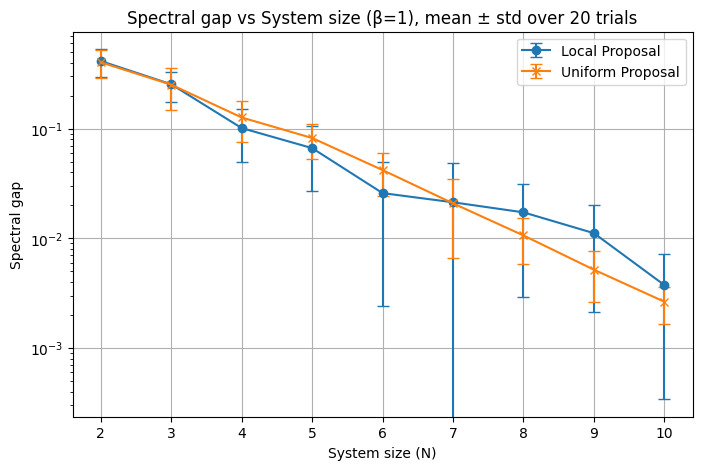

In [65]:
plt.figure(figsize=(8,5))
plt.errorbar(system_sizes, gaps_local_N, yerr=std_local_N, label='Local Proposal', marker='o', capsize=4)
plt.errorbar(system_sizes, gaps_uniform_N, yerr=std_uniform_N, label='Uniform Proposal', marker='x', capsize=4)
plt.semilogy()
plt.xlabel('System size (N)')
plt.ylabel('Spectral gap')
plt.title(f'Spectral gap vs System size (β={beta_fixed}), mean ± std over {num_trials} trials')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
# Varying beta, system size fixed
N_fixed = 8
betas = np.logspace(-1, 1, 10)
gaps_local_beta = []
gaps_uniform_beta = []
std_local_beta = []
std_uniform_beta = []

Local_proposal = get_local_proposal_matrix(N_fixed)
Uniform_proposal = get_uniform_proposal_matrix(N_fixed)

for beta in betas:
    trial_local = []
    trial_uniform = []
    for _ in range(num_trials):
        J = np.random.randn(N_fixed, N_fixed)
        J = (J + J.T) / 2
        h = np.random.randn(N_fixed)
        Energy = TFIM_Energy_vec(J, h)
        T_local = get_transition_matrix_from_proposal(N_fixed, Local_proposal, Energy, beta=beta)
        T_uniform = get_transition_matrix_from_proposal(N_fixed, Uniform_proposal, Energy, beta=beta)
        trial_local.append(get_abs_spectral_gap_from_transition_mat(T_local))
        trial_uniform.append(get_abs_spectral_gap_from_transition_mat(T_uniform))
    gaps_local_beta.append(np.mean(trial_local))
    gaps_uniform_beta.append(np.mean(trial_uniform))
    std_local_beta.append(np.std(trial_local))
    std_uniform_beta.append(np.std(trial_uniform))
